In [1]:
cd .. 

/home/jovyan/2018-W-450-4/03-learning-curves


In [2]:
run __init__.py

In [3]:
run src/load_data.py

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
from sklearn.metrics import accuracy_score, f1_score

In [6]:
# !conda install tqdm --yes

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from tqdm import tqdm 
from time import time

In [10]:
adult_train_df = data['adult']['train']['engineered']
adult_train_target = data['adult']['train']['labels']

In [11]:
def sample_training_set(X_train, y_train, n_pcnt):
    n = X_train.shape[0]*n_pcnt//100
    return n, X_train[:n], y_train[:n]

def time_function_call(function_call):
    start = time()
    result = function_call
    execution_time = time() - start
    return result, execution_time

def run_model(model, model_name, n_pcnt, data, labels):

    X_train, X_test, y_train, y_test = train_test_split(data, labels, stratify=labels)

    
    n, X_samp, y_samp = sample_training_set(X_train, y_train, n_pcnt)
    
    _, fit_time = time_function_call(
        model.fit(X_samp, y_samp))
    
    train_pred, train_pred_time = time_function_call(
        model.predict(X_samp))
    
    test_pred, test_pred_time = time_function_call(
        model.predict(X_test))    
    
    return {
            'model' : model,
            'model_name' : model_name,
            'n_pcnt' : n_pcnt,
            'n' : n,
            'f1_train_score' : f1_score(y_samp, train_pred),
            'f1_test_score' : f1_score(y_test, test_pred),
            'accuracy_train_score' : model.score(X_samp, y_samp),
            'accuracy_test_score' : model.score(X_test, y_test),
            'fit_time' : fit_time,
            'train_pred_time' : train_pred_time,
            'test_pred_time' : test_pred_time}

## Variable Ranking - by Single Feature F$_1$ Score 

In [12]:
vr_by_f1_test_scores = []
for feature in tqdm(adult_train_df.columns):
    results = run_model(LogisticRegression(), 'variable ranking', 50, adult_train_df[[feature]], adult_train_target)
    test_score = results['f1_test_score']
    if test_score > 0:
        vr_by_f1_test_scores.append({'feature': feature, 'score' : test_score})


100%|██████████| 103/103 [00:04<00:00, 24.85it/s]


In [13]:
vr_by_f1_results = pd.DataFrame(vr_by_f1_test_scores).sort_values('score', ascending=False)
vr_by_f1_results

,feature,score
1,capital-gain,0.315217
6,education_ Masters,0.195887
4,workclass_ Self-emp-inc,0.122735
7,education_ Prof-school,0.088474
5,education_ Doctorate,0.079096
2,capital-loss,0.071161
3,hours-per-week,0.049457
0,age,0.033694


In [14]:
vr_by_f1_performant_features = list(vr_by_f1_results.feature.values)
vr_by_f1_performant_features

['capital-gain',
 'education_ Masters',
 'workclass_ Self-emp-inc',
 'education_ Prof-school',
 'education_ Doctorate',
 'capital-loss',
 'hours-per-week',
 'age']

## Retrain the model

Add one feature at a time.

In [20]:
list(enumerate(['a', 'b', 'c']))

[(0, 'a'), (1, 'b'), (2, 'c')]

In [21]:
vr_by_f1_features_to_test = []
vr_by_f1_features_test_results = {}
for i, feature in tqdm(enumerate(vr_by_f1_performant_features)):
    vr_by_f1_features_to_test.append(feature)
    vr_by_f1_features_test_results[str(i)+feature] = run_model(LogisticRegression(), 'logit', 100,
                                                        adult_train_df[vr_by_f1_features_to_test],
                                                        adult_train_target)

8it [00:00, 11.39it/s]


In [22]:
vr_by_f1_performant_features

['capital-gain',
 'education_ Masters',
 'workclass_ Self-emp-inc',
 'education_ Prof-school',
 'education_ Doctorate',
 'capital-loss',
 'hours-per-week',
 'age']

In [23]:
vr_by_f1_features_test_results = pd.DataFrame(vr_by_f1_features_test_results).T
vr_by_f1_features_test_results

,accuracy_test_score,accuracy_train_score,f1_test_score,f1_train_score,fit_time,model,model_name,n,n_pcnt,test_pred_time,train_pred_time
0capital-gain,0.799617,0.797426,0.327623,0.320913,7.15256e-06,"LogisticRegression(C=1.0, class_weight=None, d...",logit,18803,100,5.00679e-06,5.48363e-06
1education_ Masters,0.793076,0.799766,0.292417,0.324179,8.10623e-06,"LogisticRegression(C=1.0, class_weight=None, d...",logit,18803,100,6.19888e-06,7.62939e-06
2workclass_ Self-emp-inc,0.801372,0.798543,0.33244,0.321633,8.10623e-06,"LogisticRegression(C=1.0, class_weight=None, d...",logit,18803,100,5.48363e-06,6.19888e-06
3education_ Prof-school,0.805361,0.804127,0.365245,0.368592,7.86781e-06,"LogisticRegression(C=1.0, class_weight=None, d...",logit,18803,100,4.52995e-06,8.58307e-06
4education_ Doctorate,0.807754,0.808116,0.400199,0.398466,8.34465e-06,"LogisticRegression(C=1.0, class_weight=None, d...",logit,18803,100,5.72205e-06,8.82149e-06
5capital-loss,0.805839,0.806414,0.384421,0.38032,1.00136e-05,"LogisticRegression(C=1.0, class_weight=None, d...",logit,18803,100,6.4373e-06,8.10623e-06
6hours-per-week,0.812221,0.811094,0.454335,0.457047,6.67572e-06,"LogisticRegression(C=1.0, class_weight=None, d...",logit,18803,100,5.24521e-06,1.19209e-05
7age,0.812221,0.811679,0.456351,0.456485,1.04904e-05,"LogisticRegression(C=1.0, class_weight=None, d...",logit,18803,100,6.4373e-06,7.62939e-06


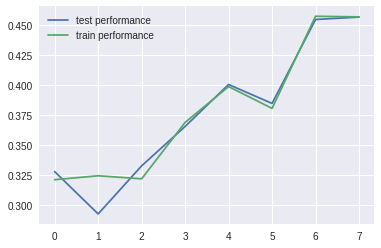

In [24]:
plt.plot(range(len(vr_by_f1_features_to_test)), vr_by_f1_features_test_results.f1_test_score, label='test performance')
plt.plot(range(len(vr_by_f1_features_to_test)), vr_by_f1_features_test_results.f1_train_score, label='train performance')
plt.legend()


## Variable-Ranking - By Regression Coefficient in Full Model

In [25]:
simple_model_results = run_model(LogisticRegression(), 'logit', 100,
                                 adult_train_df,
                                 adult_train_target)

In [26]:
simple_model_results

{'accuracy_test_score': 0.85561582641991063,
 'accuracy_train_score': 0.84747114822102854,
 'f1_test_score': 0.66319315221436548,
 'f1_train_score': 0.64801178203240062,
 'fit_time': 7.152557373046875e-06,
 'model': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False),
 'model_name': 'logit',
 'n': 18803,
 'n_pcnt': 100,
 'test_pred_time': 8.821487426757812e-06,
 'train_pred_time': 3.409385681152344e-05}

In [27]:
simple_logistic_regression_model = simple_model_results['model']

In [28]:
coefficients = simple_logistic_regression_model.coef_
features = adult_train_df.columns
coefficients = pd.Series(coefficients.T.ravel(), index=features)
coefficients.head()

age                       0.020005
capital-gain              0.000295
capital-loss              0.000618
hours-per-week            0.030374
workclass_ Federal-gov    0.523605
dtype: float64

In [29]:
sorted_coefs = np.abs(coefficients).sort_values(ascending=False)
sorted_coefs.head(20)

sex_ Female                           1.676864
relationship_ Own-child               1.442219
marital-status_ Never-married         1.162129
education_ Prof-school                1.144781
education_ 7th-8th                    1.142871
relationship_ Wife                    1.127511
education_ 10th                       1.032183
occupation_ Farming-fishing           0.972133
occupation_ Exec-managerial           0.906734
education_ Masters                    0.883535
education_ 11th                       0.858726
occupation_ Other-service             0.836131
education_ Doctorate                  0.828554
education_ 9th                        0.743703
marital-status_ Married-civ-spouse    0.734074
occupation_ Tech-support              0.728565
native-country_ Mexico                0.725203
relationship_ Other-relative          0.719350
occupation_ Handlers-cleaners         0.716865
sex_ Male                             0.705181
dtype: float64

In [30]:
vr_by_coef_performant_features = list(sorted_coefs.head(20).index)
vr_by_coef_performant_features

['sex_ Female',
 'relationship_ Own-child',
 'marital-status_ Never-married',
 'education_ Prof-school',
 'education_ 7th-8th',
 'relationship_ Wife',
 'education_ 10th',
 'occupation_ Farming-fishing',
 'occupation_ Exec-managerial',
 'education_ Masters',
 'education_ 11th',
 'occupation_ Other-service',
 'education_ Doctorate',
 'education_ 9th',
 'marital-status_ Married-civ-spouse',
 'occupation_ Tech-support',
 'native-country_ Mexico',
 'relationship_ Other-relative',
 'occupation_ Handlers-cleaners',
 'sex_ Male']

In [58]:
str(2).zfill(3)

'002'

In [59]:
vr_by_coef_features_to_test = []
vr_by_coef_test_results = {}
for i, feature in tqdm(enumerate(vr_by_coef_performant_features)):
    vr_by_coef_features_to_test.append(feature)
    vr_by_coef_test_results[str(i).zfill(3)+feature] = run_model(LogisticRegression(), 'logit', 100,
                                                 adult_train_df[vr_by_coef_features_to_test],
                                                 adult_train_target)

20it [00:01, 15.72it/s]


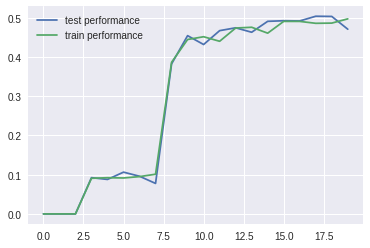

In [60]:
vr_by_coef_test_results = pd.DataFrame(vr_by_coef_test_results).T

plt.plot(range(len(vr_by_coef_features_to_test)), vr_by_coef_test_results.f1_test_score, label='test performance')
plt.plot(range(len(vr_by_coef_features_to_test)), vr_by_coef_test_results.f1_train_score, label='train performance')
plt.legend()

In [61]:
vr_by_coef_with_num_features_to_test = ['age', 'capital-gain','capital-loss','hours-per-week']
vr_by_coef_with_num_test_results = {}
for i, feature in tqdm(enumerate(vr_by_coef_performant_features)):
    vr_by_coef_with_num_features_to_test.append(feature)
    vr_by_coef_with_num_test_results[str(i).zfill(3)+feature] = run_model(LogisticRegression(), 'logit', 100,
                                                          adult_train_df[vr_by_coef_with_num_features_to_test],
                                                          adult_train_target)

20it [00:04,  4.90it/s]


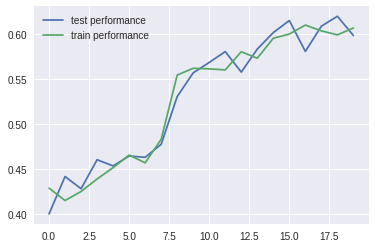

In [62]:
vr_by_coef_with_num_test_results = pd.DataFrame(vr_by_coef_with_num_test_results).T

plt.plot(range(len(vr_by_coef_with_num_features_to_test)-4), vr_by_coef_with_num_test_results.f1_test_score, label='test performance')
plt.plot(range(len(vr_by_coef_with_num_features_to_test)-4), vr_by_coef_with_num_test_results.f1_train_score, label='train performance')
plt.legend()

## Variable-Ranking - By Information Gain in Full Model

In [35]:
simple_dtree_results = run_model(DecisionTreeClassifier(), 'dtree', 100,
                                 adult_train_df,
                                 adult_train_target)

In [36]:
simple_dtree_results

{'accuracy_test_score': 0.81477345245692401,
 'accuracy_train_score': 0.98181141307238207,
 'f1_test_score': 0.61390089790488855,
 'f1_train_score': 0.96118928733545173,
 'fit_time': 1.2159347534179688e-05,
 'model': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False, random_state=None,
             splitter='best'),
 'model_name': 'dtree',
 'n': 18803,
 'n_pcnt': 100,
 'test_pred_time': 1.0728836059570312e-05,
 'train_pred_time': 8.58306884765625e-06}

In [37]:
simple_decision_tree_model = simple_dtree_results['model']

In [38]:
feature_importances = simple_decision_tree_model.feature_importances_
features = adult_train_df.columns
feature_importances = pd.Series(feature_importances.T.ravel(), index=features)
feature_importances.head()

age                       0.173681
capital-gain              0.125606
capital-loss              0.058387
hours-per-week            0.088420
workclass_ Federal-gov    0.005809
dtype: float64

In [39]:
sorted_importances = feature_importances.sort_values(ascending=False)
sorted_coefs = np.abs(coefficients).sort_values(ascending=False)
sorted_importances = pd.DataFrame(sorted_importances, columns=['importances'])
sorted_importances['importance_feature'] = sorted_importances.index
sorted_importances.reset_index(drop=True, inplace=True)

sorted_coefs = pd.DataFrame(sorted_coefs, columns=['regression coefs'])
sorted_coefs['reg_coef_feature'] = sorted_coefs.index
sorted_coefs.reset_index(drop=True, inplace=True)
sorted_feats = pd.merge(sorted_importances, sorted_coefs, left_index=True, right_index=True)
sorted_feats.head(10)

,importances,importance_feature,regression coefs,reg_coef_feature
0,0.209090,marital-status_ Married-civ-spouse,1.676864,sex_ Female
1,0.173681,age,1.442219,relationship_ Own-child
2,0.125606,capital-gain,1.162129,marital-status_ Never-married
3,0.088420,hours-per-week,1.144781,education_ Prof-school
4,0.058387,capital-loss,1.142871,education_ 7th-8th
5,0.025806,education_ Bachelors,1.127511,relationship_ Wife
6,0.025557,occupation_ Prof-specialty,1.032183,education_ 10th
7,0.021670,occupation_ Exec-managerial,0.972133,occupation_ Farming-fishing
8,0.017321,workclass_ Private,0.906734,occupation_ Exec-managerial
9,0.011850,occupation_ Sales,0.883535,education_ Masters


In [40]:
importance_performant_features = list(sorted_feats.importance_feature.head(20))
importance_performant_features

['marital-status_ Married-civ-spouse',
 'age',
 'capital-gain',
 'hours-per-week',
 'capital-loss',
 'education_ Bachelors',
 'occupation_ Prof-specialty',
 'occupation_ Exec-managerial',
 'workclass_ Private',
 'occupation_ Sales',
 'education_ Masters',
 'workclass_ Self-emp-not-inc',
 'native-country_ United-States',
 'race_ White',
 'education_ HS-grad',
 'occupation_ Craft-repair',
 'workclass_ Local-gov',
 'occupation_ Adm-clerical',
 'occupation_ Transport-moving',
 'workclass_ State-gov']

In [63]:
vr_importance_features_to_test = []
vr_importance_test_results = {}
for i, feature in tqdm(enumerate(importance_performant_features)):
    vr_importance_features_to_test.append(feature)
    vr_importance_test_results[str(i).zfill(3)+feature+'_dtree'] = run_model(DecisionTreeClassifier(), 'dtree', 50,
                                                             adult_train_df[vr_importance_features_to_test],
                                                             adult_train_target)
    vr_importance_test_results[str(i).zfill(3)+feature+'_logit'] = run_model(LogisticRegression(), 'logit', 50,
                                                             adult_train_df[vr_importance_features_to_test],
                                                             adult_train_target)

20it [00:02,  6.69it/s]


In [64]:
vr_importance_test_results = pd.DataFrame(vr_importance_test_results).T

In [65]:
dtree_results = vr_importance_test_results[vr_importance_test_results.model_name == 'dtree']
logit_results = vr_importance_test_results[vr_importance_test_results.model_name == 'logit']

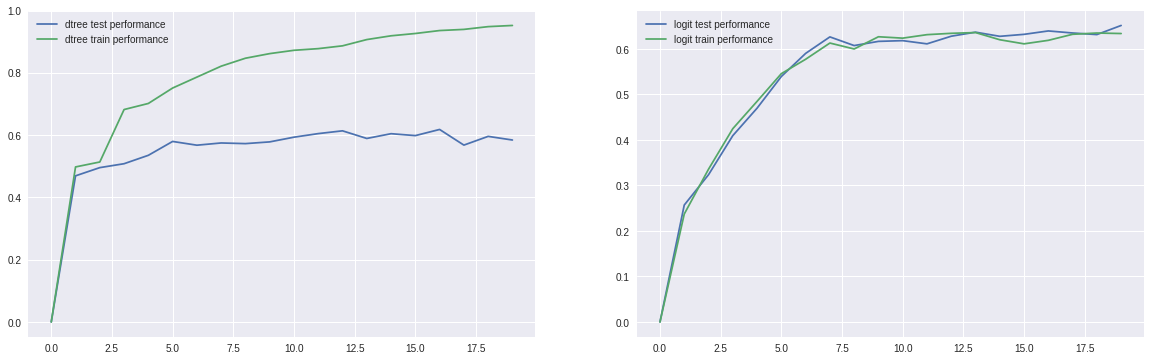

In [66]:
fig = plt.figure(figsize=(20,6))
fig.add_subplot(1,2,1)
plt.plot(range(len(vr_importance_features_to_test)), dtree_results.f1_test_score, label='dtree test performance')
plt.plot(range(len(vr_importance_features_to_test)), dtree_results.f1_train_score, label='dtree train performance')
plt.legend()
fig.add_subplot(1,2,2)
plt.plot(range(len(vr_importance_features_to_test)), logit_results.f1_test_score, label='logit test performance')
plt.plot(range(len(vr_importance_features_to_test)), logit_results.f1_train_score, label='logit train performance')
plt.legend()

In [67]:
whos list

Variable                               Type    Data/Info
--------------------------------------------------------
imp_feat_no_masters                    list    n=19
imp_feat_no_self                       list    n=19
importance_performant_features         list    n=20
numeric_features                       list    n=4
vr_by_coef_features_to_test            list    n=20
vr_by_coef_performant_features         list    n=20
vr_by_coef_with_num_features_to_test   list    n=24
vr_by_f1_features_to_test              list    n=8
vr_by_f1_performant_features           list    n=8
vr_by_f1_test_scores                   list    n=8
vr_importance_features_to_test         list    n=20
vr_importance_features_to_test_1       list    n=19


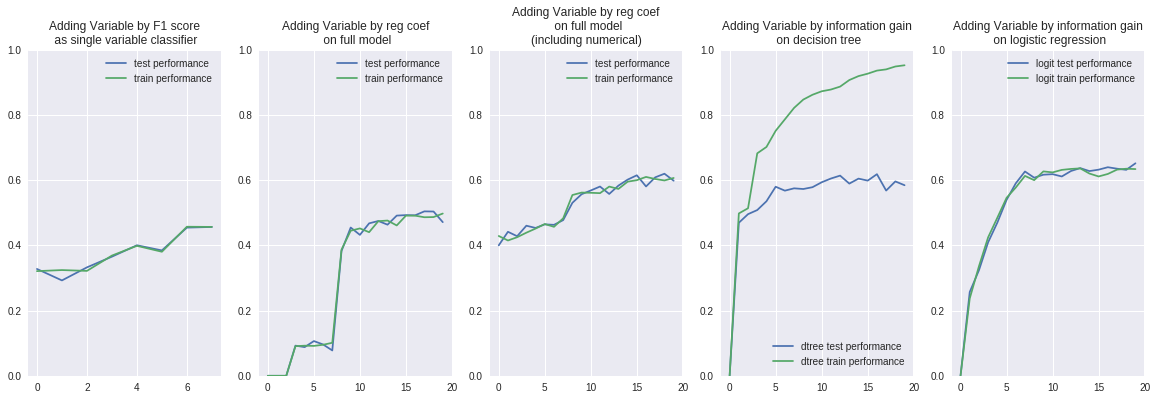

In [68]:

fig = plt.figure(figsize=(20,6))

fig.add_subplot(1,5,1)
plt.plot(range(len(vr_by_f1_features_to_test)), vr_by_f1_features_test_results.f1_test_score, label='test performance')
plt.plot(range(len(vr_by_f1_features_to_test)), vr_by_f1_features_test_results.f1_train_score, label='train performance')
plt.title('Adding Variable by F1 score\n as single variable classifier')
plt.ylim(0,1)
plt.legend()

fig.add_subplot(1,5,2)
plt.plot(range(len(vr_by_coef_features_to_test)), vr_by_coef_test_results.f1_test_score, label='test performance')
plt.plot(range(len(vr_by_coef_features_to_test)), vr_by_coef_test_results.f1_train_score, label='train performance')
plt.title('Adding Variable by reg coef\n on full model')
plt.ylim(0,1)
plt.legend()

fig.add_subplot(1,5,3)
plt.plot(range(len(vr_by_coef_with_num_features_to_test)-4), vr_by_coef_with_num_test_results.f1_test_score, label='test performance')
plt.plot(range(len(vr_by_coef_with_num_features_to_test)-4), vr_by_coef_with_num_test_results.f1_train_score, label='train performance')
plt.title('Adding Variable by reg coef\n on full model\n(including numerical)')
plt.ylim(0,1)
plt.legend()

fig.add_subplot(1,5,4)
plt.plot(range(len(vr_importance_features_to_test)), dtree_results.f1_test_score, label='dtree test performance')
plt.plot(range(len(vr_importance_features_to_test)), dtree_results.f1_train_score, label='dtree train performance')
plt.title('Adding Variable by information gain\n on decision tree')
plt.ylim(0,1)
plt.legend()

fig.add_subplot(1,5,5)
plt.plot(range(len(vr_importance_features_to_test)), logit_results.f1_test_score, label='logit test performance')
plt.plot(range(len(vr_importance_features_to_test)), logit_results.f1_train_score, label='logit train performance')
plt.title('Adding Variable by information gain\n on logistic regression')
plt.ylim(0,1)
plt.legend()

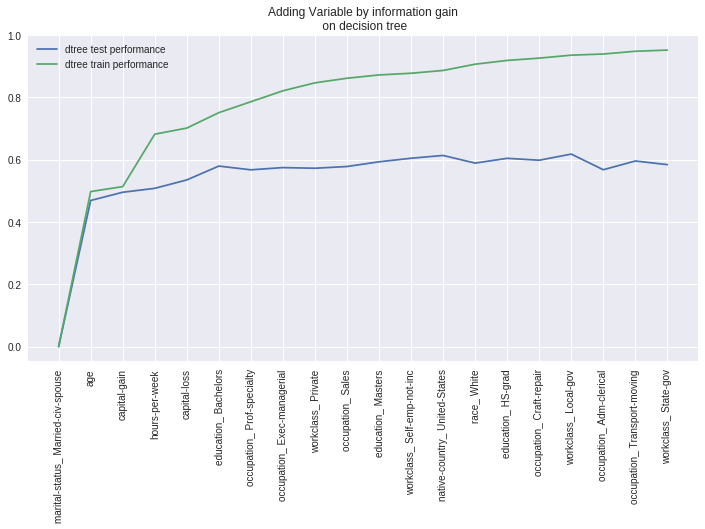

In [70]:
plt.figure(figsize=(12,6))
plt.plot(range(len(vr_importance_features_to_test)), dtree_results.f1_test_score, label='dtree test performance')
plt.plot(range(len(vr_importance_features_to_test)), dtree_results.f1_train_score, label='dtree train performance')
plt.title('Adding Variable by information gain\n on decision tree')
plt.xticks(range(len(vr_importance_features_to_test)), vr_importance_features_to_test, rotation='vertical')
plt.legend()



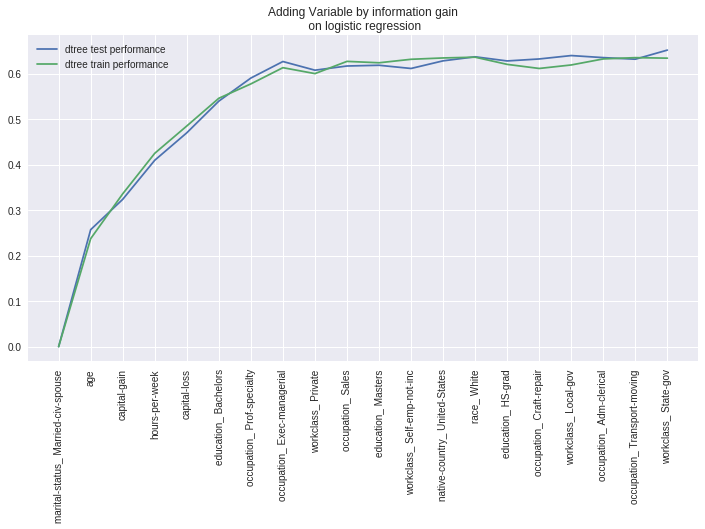

In [71]:
plt.figure(figsize=(12,6))
plt.plot(range(len(vr_importance_features_to_test)), logit_results.f1_test_score, label='dtree test performance')
plt.plot(range(len(vr_importance_features_to_test)), logit_results.f1_train_score, label='dtree train performance')
plt.title('Adding Variable by information gain\n on logistic regression')
plt.xticks(range(len(vr_importance_features_to_test)), vr_importance_features_to_test, rotation='vertical')
plt.legend()




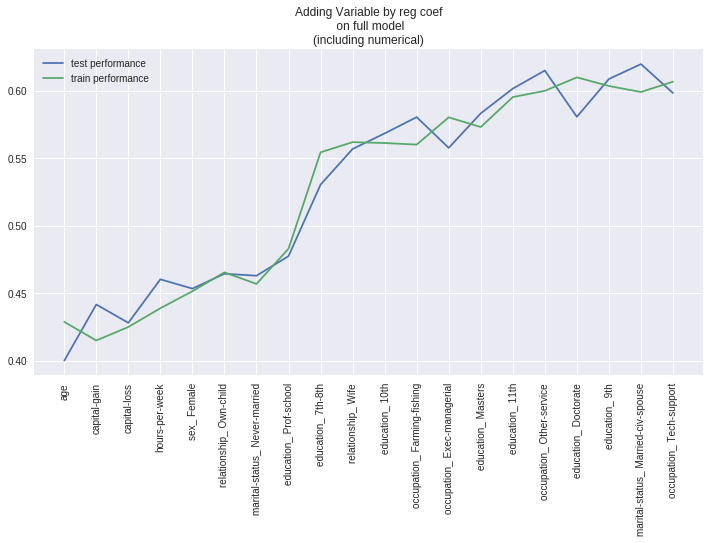

In [73]:
plt.figure(figsize=(12,6))
plt.plot(range(len(vr_by_coef_with_num_features_to_test)-4), vr_by_coef_with_num_test_results.f1_test_score, label='test performance')
plt.plot(range(len(vr_by_coef_with_num_features_to_test)-4), vr_by_coef_with_num_test_results.f1_train_score, label='train performance')
plt.title('Adding Variable by reg coef\n on full model\n(including numerical)')
plt.xticks(range(len(vr_by_coef_with_num_features_to_test)-4), vr_by_coef_with_num_features_to_test, rotation='vertical')
plt.legend()

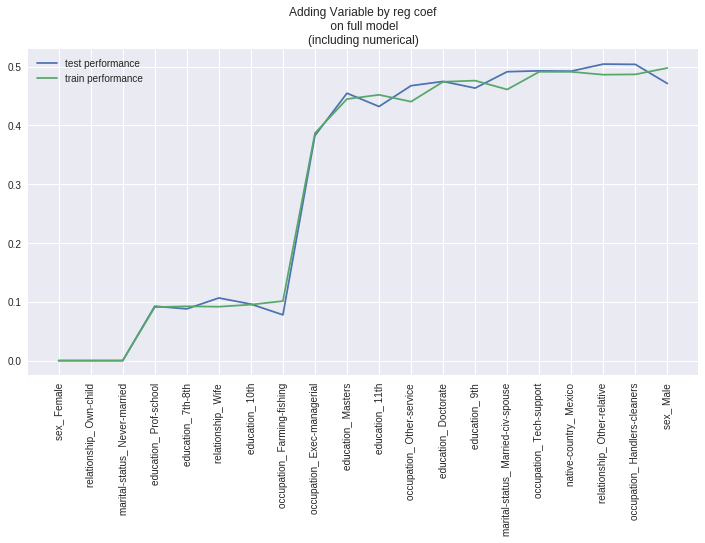

In [75]:
plt.figure(figsize=(12,6))
plt.plot(range(len(vr_by_coef_features_to_test)), vr_by_coef_test_results.f1_test_score, label='test performance')
plt.plot(range(len(vr_by_coef_features_to_test)), vr_by_coef_test_results.f1_train_score, label='train performance')
plt.title('Adding Variable by reg coef\n on full model\n(including numerical)')
plt.xticks(range(len(vr_by_coef_features_to_test)), vr_by_coef_features_to_test, rotation='vertical')
plt.legend()